# This notebook is for the Fair-Shapely experiment

In [1]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [3]:
from src.data.unified_dataloader import load_dataset

a, processed_compas4race= load_dataset('compas4race')

In [4]:
processed_compas4race.head(3)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,-0.061334,1,-0.162011,-0.195526,-0.227625,-0.735792,1,0,1,0,1,0,1
1,1,-0.901239,1,-0.162011,-0.195526,1.703263,0.059694,1,0,1,0,1,0,1
2,1,-0.985229,1,-0.162011,1.785502,-0.227625,-0.536921,1,0,1,1,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [5]:
'''COMPAS for race research'''
df = processed_compas4race.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (4305, 13)
X_test shape: (1845, 13)


### 4. Train the original model

In [6]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6601626016260163


In [7]:
X_train['race'].value_counts()

race
1    2584
0    1721
Name: count, dtype: int64

In [8]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['race'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['race'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [9]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["race"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')

c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


original_test_DR: 0.07690923660993576
original_train_DR: 0.07931391894817352


In [10]:
from fairness_measures import marginalised_np_mat, grp1_DP, grp2_EO, grp3_PQP
priv_idx = X_test['sex'].to_numpy().astype(bool)
y_hat = y_pred
y = y_test
g1_Cm, g0_Cm = marginalised_np_mat(y, y_hat, 1, priv_idx)
fair_grp1 = grp1_DP(g1_Cm, g0_Cm)[0]
fair_grp2 = grp2_EO(g1_Cm, g0_Cm)[0]
fair_grp3 = grp3_PQP(g1_Cm, g0_Cm)[0]
print(f'fair_grp1_DP: {fair_grp1}')
print(f'fair_grp2_EO: {fair_grp2}')
print(f'fair_grp3_PQP: {fair_grp3}')

fair_grp1_DP: 0.17928179590774723
fair_grp2_EO: 0.1563401090223649
fair_grp3_PQP: 0.0645931449502879


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

2. 初始化FairnessExplainer
--------接下来先对minority group进行修改--------
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
在X_train_minority中shapely value中大于0.1的值的个数有: 176
--------接下来对majority group进行修改--------
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
在X_train_majority中shapely value中大于0.1的值的个数有: 378
6. 开始整理minority部分的修改和majority部分的修改并且合并新数据,共修改554个数据点, 使用new training set训练新模型


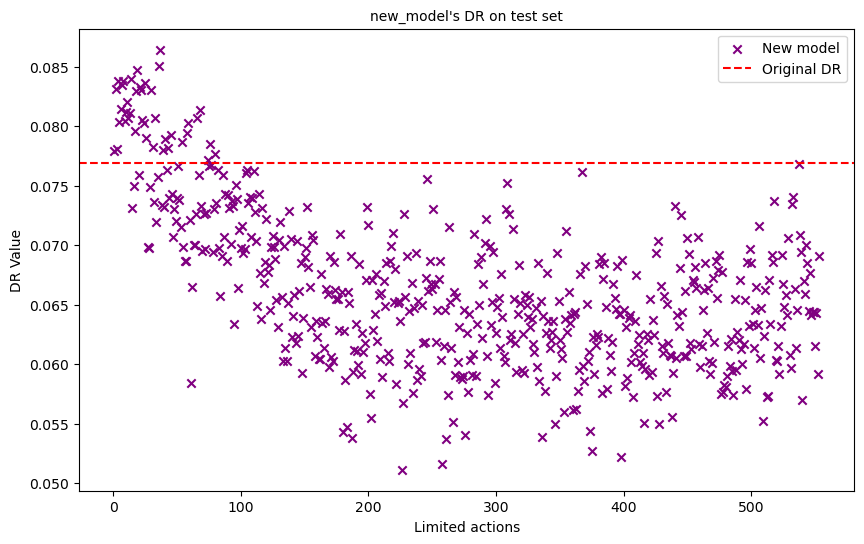

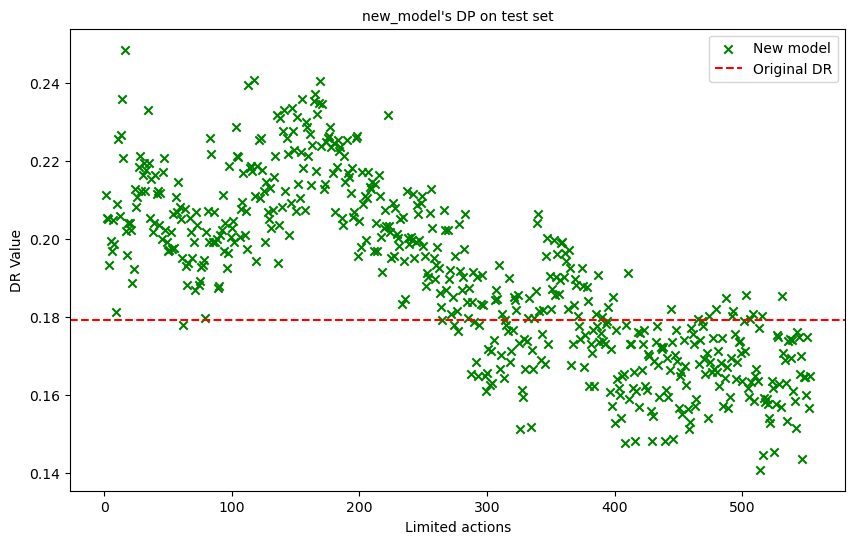

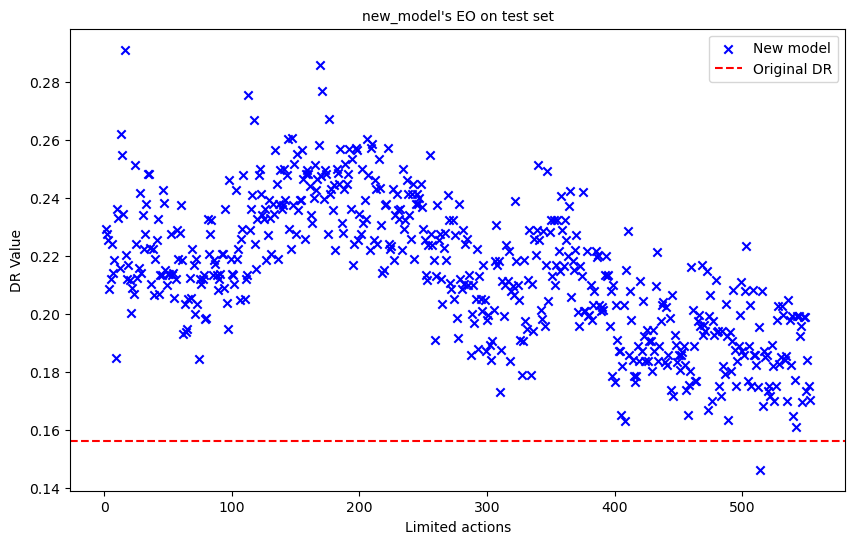

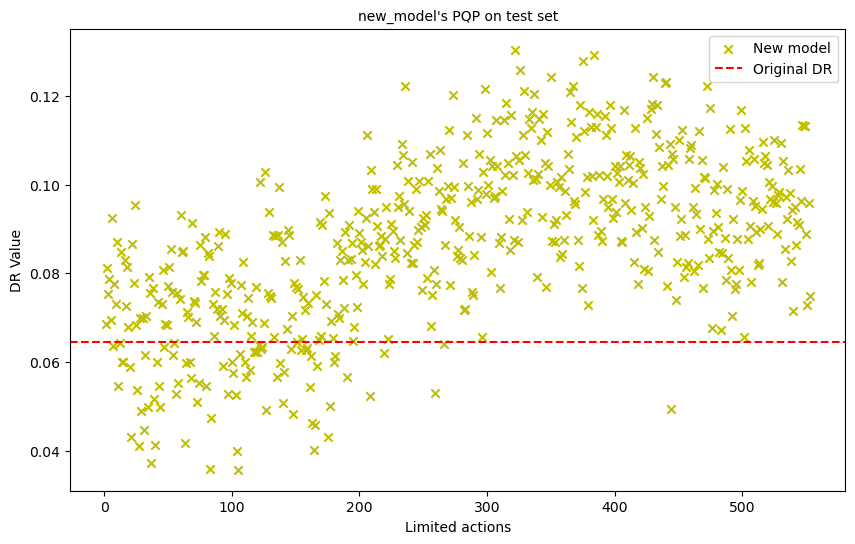

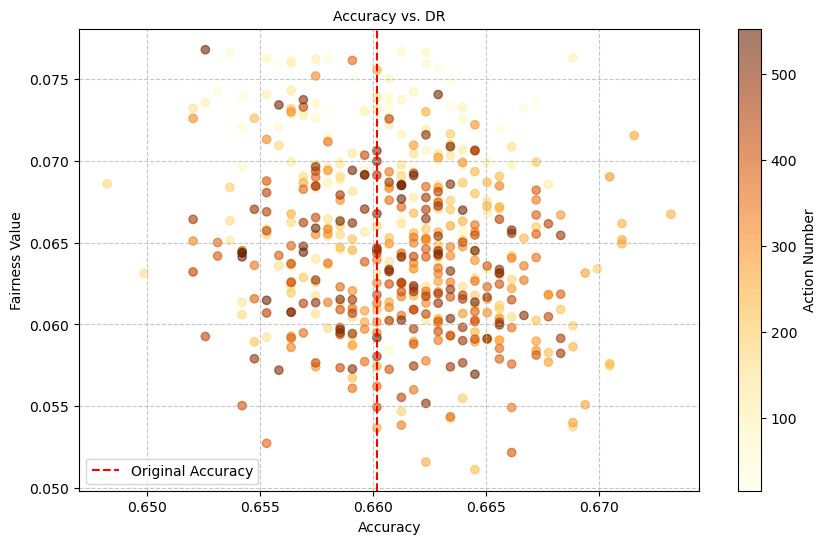

In [13]:
from src.fairshap_experiment import ExperimentDR
''' 改变minority group中的部分特征值'''

experiment = ExperimentDR(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas4race',
                            fairshap_base='PQP',
                            original_Xtest_DR = original_test_DR,
                            original_Xtest_acc = accuracy,
                            original_Xtest_DP = fair_grp1,
                            original_Xtest_EO = fair_grp2,
                            original_Xtest_PQP = fair_grp3,
                            )
experiment.run_experiment()


1. 把X_train_majority和X_train_minority分别分成X_train_majority_label1, X_train_majority_label0, X_train_minority_label1, X_train_minority_label0
2. matching
2(a). 将X_train_majority_label1与X_train_minority_label1进行匹配
2(b). 将X_train_majority_label0与X_train_minority_label0进行匹配
2(c). 将X_train_minority_label1与X_train_majority_label1进行匹配
2(d). 将X_train_minority_label0与X_train_majority_label0进行匹配
3. 前4个使用np.vstack组成X_change， 计算出后与之匹配的q，把4个q使用np.vstack组成X_base
3(a). 挑出X_train_minority_label1中与'X_train_majority_label1中每个instance'最近的instance,
3(b). 挑出X_train_minority_label0中与'X_train_majority_label0中每个instance'最近的instance,
3(c). 挑出X_train_majority_label1中与'X_train_minority_label1中每个instance'最近的instance,
3(d). 挑出X_train_majority_label0中与'X_train_minority_label0中每个instance'最近的instance,
4. 在X_change的所有值中挑500个位置，把这些位置的值替换成X_base里的值


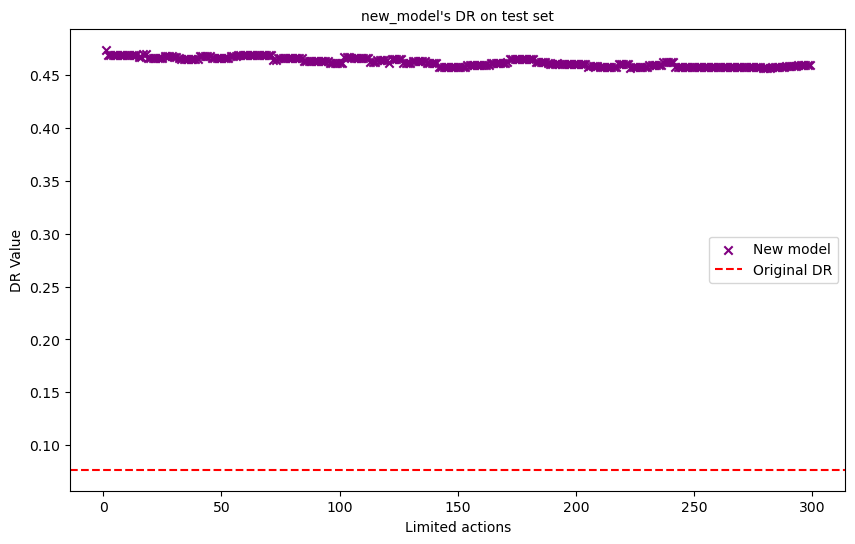

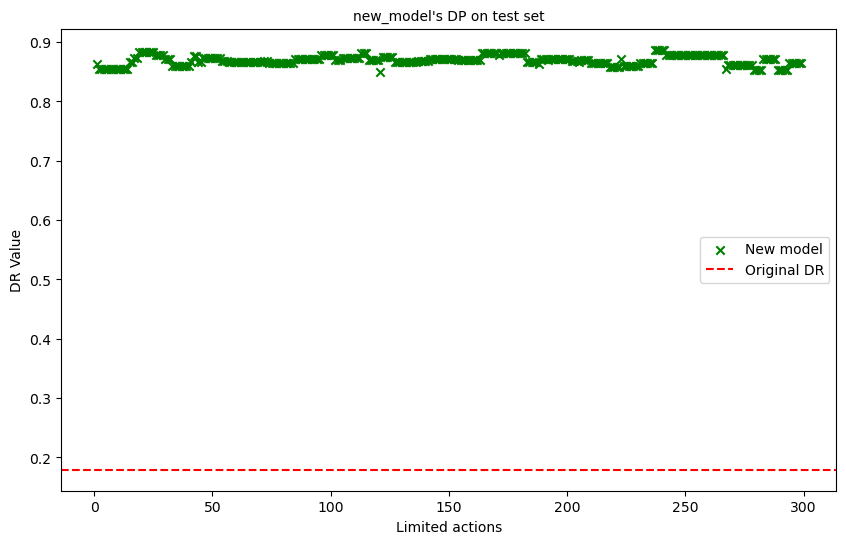

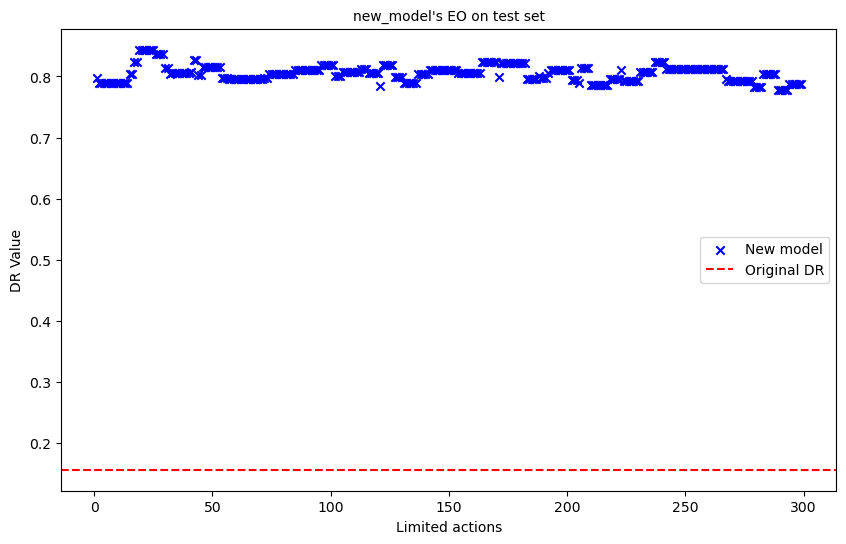

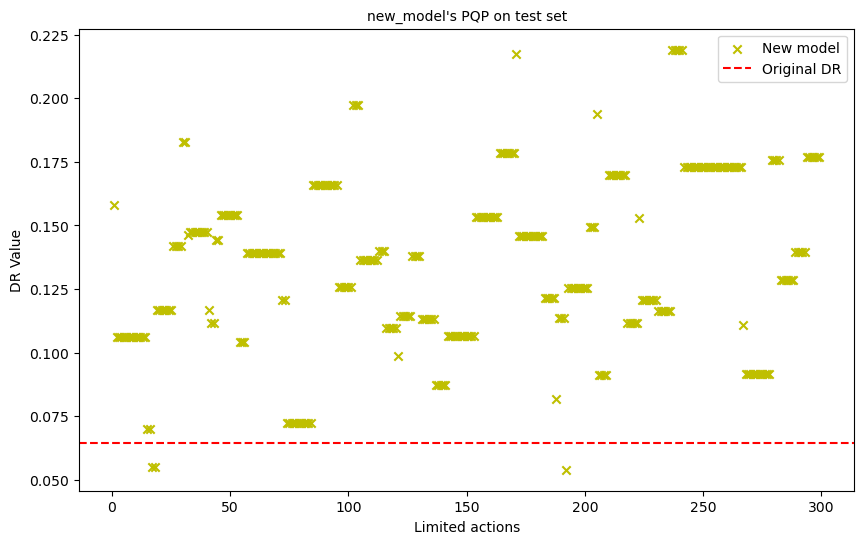

1. 把X_train_majority和X_train_minority分别分成X_train_majority_label1, X_train_majority_label0, X_train_minority_label1, X_train_minority_label0
2. matching
2(a). 将X_train_majority_label1与X_train_minority_label1进行匹配
2(b). 将X_train_majority_label0与X_train_minority_label0进行匹配
2(c). 将X_train_minority_label1与X_train_majority_label1进行匹配
2(d). 将X_train_minority_label0与X_train_majority_label0进行匹配
3. 前4个使用np.vstack组成X_change， 计算出后与之匹配的q，把4个q使用np.vstack组成X_base
3(a). 挑出X_train_minority_label1中与'X_train_majority_label1中每个instance'最近的instance,
3(b). 挑出X_train_minority_label0中与'X_train_majority_label0中每个instance'最近的instance,
3(c). 挑出X_train_majority_label1中与'X_train_minority_label1中每个instance'最近的instance,
3(d). 挑出X_train_majority_label0中与'X_train_minority_label0中每个instance'最近的instance,
4. 在X_change的sensitive attribute列中挑500个位置，把这些位置的值替换成X_base里的值


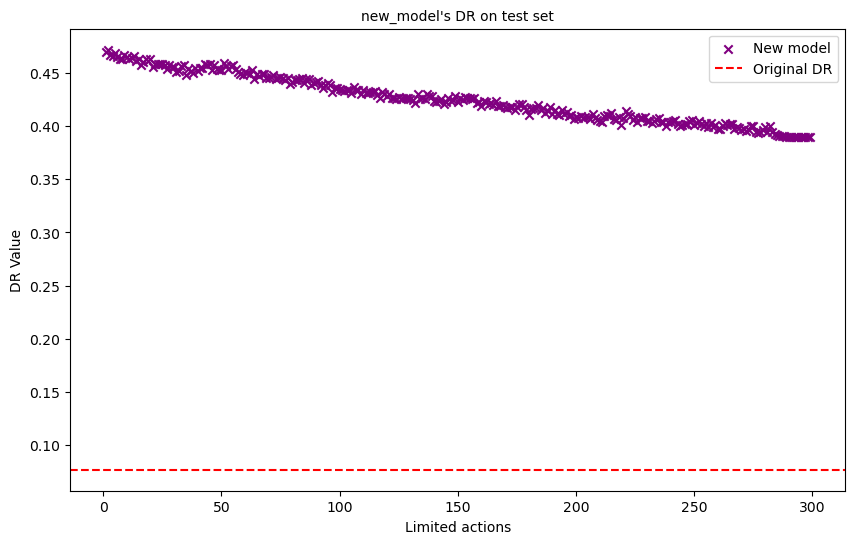

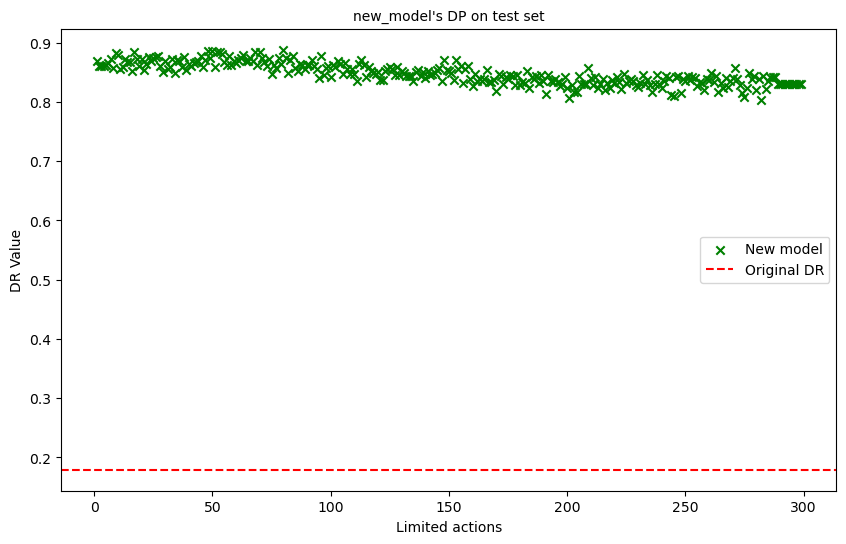

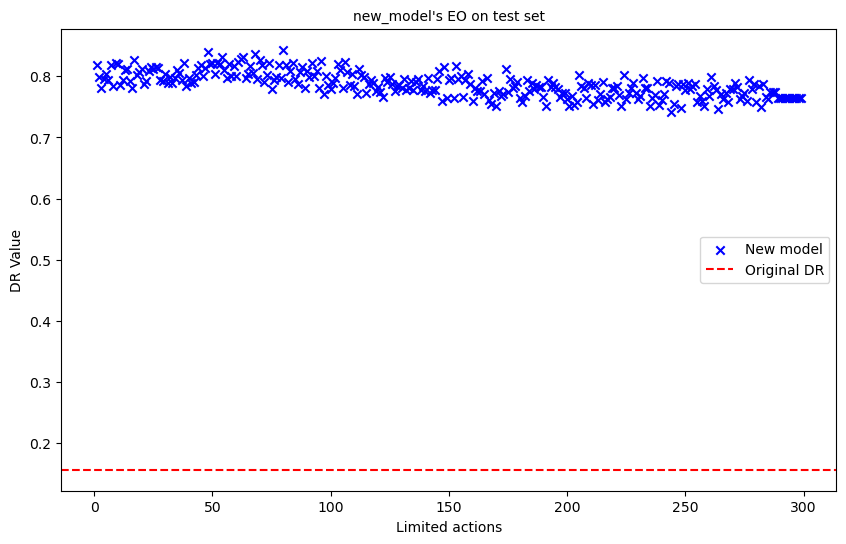

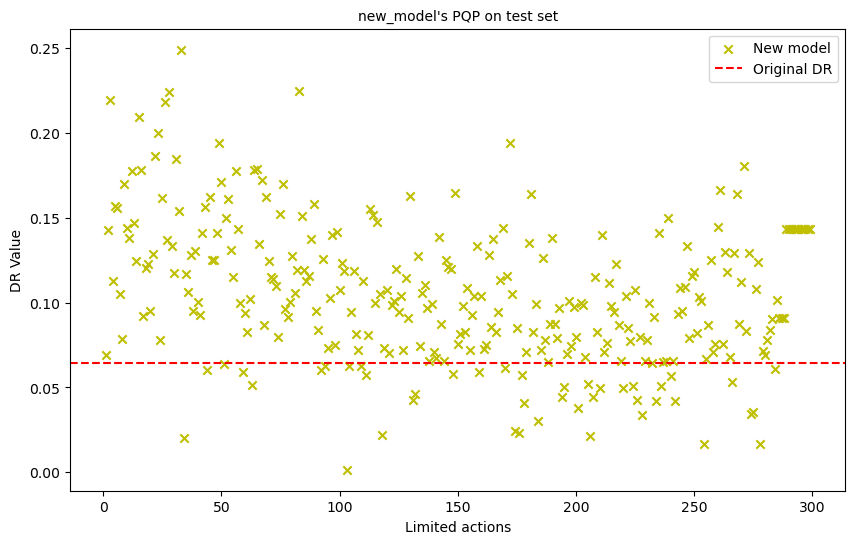

In [25]:
from src.fairshap_baseline import Baseline

baseline_experiment = Baseline(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas4race',
                            original_Xtest_DR = original_test_DR,
                            original_Xtest_acc = accuracy,
                            original_Xtest_DP = fair_grp1,
                            original_Xtest_EO = fair_grp2,
                            original_Xtest_PQP = fair_grp3,
                            )
baseline_experiment.baseline1()
baseline_experiment.baseline2()